# Risk Analysis

Demonstrate suncal's risk tool by recreating figures in "How to maintain confidence in a world of declining test uncertainty ratios" by David Deaver, Fluke.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from suncal import risk

## Out of tolerance Probability (Deaver Figure 3)

Out of tolerance probability can be computed using `risk.specific_risk`. Deaver's paper assumes normal distribution and symmetric specification limits, but `specific_risk` function can calculate using any scipy.stats distribution and arbitrary limits on either side.

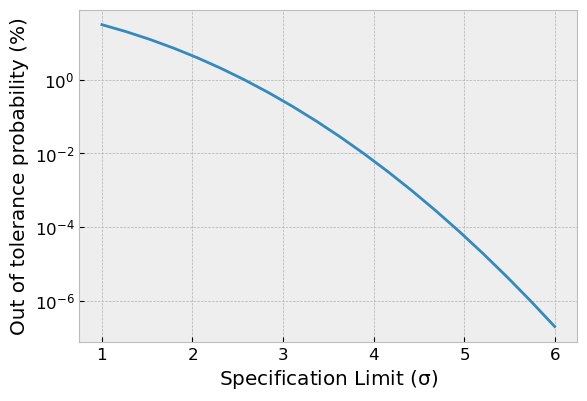

In [2]:
dproc = stats.norm(loc=0, scale=1)
sigmalist = np.linspace(1, 6, num=20)
oot = np.zeros(len(sigmalist))
for i, sigma in enumerate(sigmalist):
    _, oot[i], _, _ = risk.specific_risk(dproc, -sigma, sigma)

plt.plot(sigmalist, oot*100)
plt.yscale('log')
plt.xlabel('Specification Limit ($\sigma$)')
plt.ylabel('Out of tolerance probability (%)');

## Consumer Risk and Producer Risk as Function of TUR (Deaver Figure 8)

When both process and test distributions are normal and the spec limits are given in terms of standard deviations, the `risk.PFA_deaver` and `risk.PFR_deaver` functions can be used to find probability of false accept and reject. These functions will be faster than the generic `risk.PFA` and `risk.PFR` functions which can operate on arbitrary distributions. Note that Deaver's definition of TUR is the uncertainty of the process distribution over the uncertainty of the test distribution, not the typical spec limits over test distribution. The `risk.PFx_deaver` functions account for this.

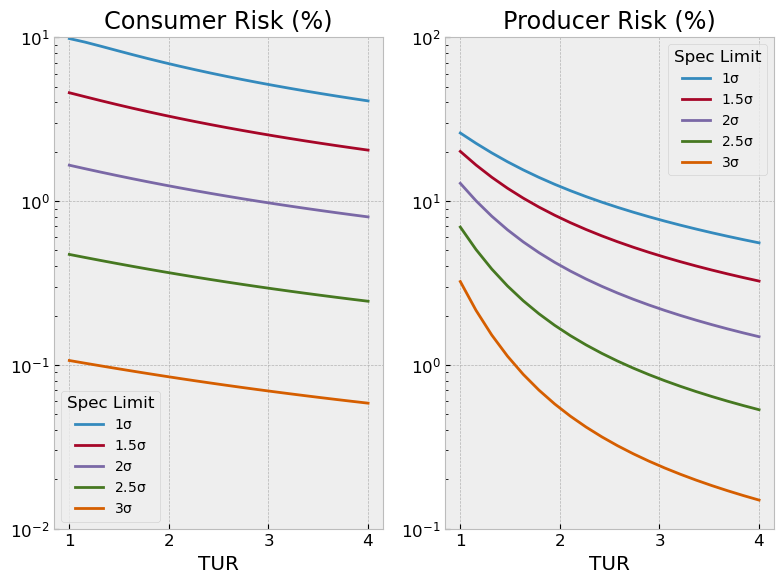

In [3]:
SLlist = np.array([1, 1.5, 2, 2.5, 3])
TURlist = np.linspace(1, 4, num=20)

fig, axs = plt.subplots(ncols=2, figsize=(8, 6))

PFA = np.zeros((len(SLlist), len(TURlist)))
PFR = np.zeros((len(SLlist), len(TURlist)))
for j, SL in enumerate(SLlist):
    for i, TUR in enumerate(TURlist):
        PFA[j, i] = risk.PFA_deaver(SL, TUR) * 100  # Percent
        PFR[j, i] = risk.PFR_deaver(SL, TUR) * 100
    axs[0].plot(TURlist, PFA[j,:], label='{:g}$\sigma$'.format(SLlist[j]))
    axs[1].plot(TURlist, PFR[j,:], label='{:g}$\sigma$'.format(SLlist[j]))

axs[0].set_xlabel('TUR')
axs[1].set_xlabel('TUR')
axs[0].set_title('Consumer Risk (%)')
axs[1].set_title('Producer Risk (%)')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_ylim(.01, 10)
axs[1].set_ylim(.1, 100)
axs[0].legend(loc='best', title='Spec Limit', fontsize=10)
axs[1].legend(loc='best', title='Spec Limit', fontsize=10)
fig.tight_layout()

## Consumer and Producer Risk with Guardband (Deaver Appendix A - Figures 12-16)

Generate Figures 12-16 in Deaver's paper - guardbanded risk. Change `SL` value and adjust the y limits to get the different figures.

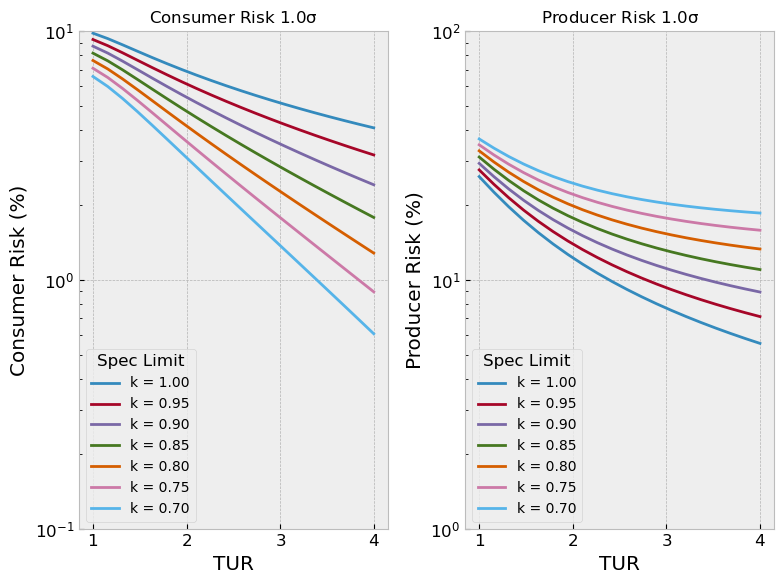

In [4]:
SL = 1
TURlist = np.linspace(1, 4, num=20)
GBlist = np.array([1, .95, .90, .85, .80, .75, .70])

fig, axs = plt.subplots(ncols=2, figsize=(8, 6))
PFA = np.zeros((len(GBlist), len(TURlist)))
PFR = np.zeros((len(GBlist), len(TURlist)))

for j, GB in enumerate(GBlist):
    for i, TUR in enumerate(TURlist):
        PFA[j, i] = risk.PFA_deaver(SL, TUR, GB=GB) * 100  # Percent
        PFR[j, i] = risk.PFR_deaver(SL, TUR, GB=GB) * 100

    axs[0].plot(TURlist, PFA[j,:], label='k = {:.2f}'.format(GBlist[j]))
    axs[1].plot(TURlist, PFR[j,:], label='k = {:.2f}'.format(GBlist[j]))

axs[0].set_xlabel('TUR')
axs[1].set_xlabel('TUR')
axs[0].set_ylabel('Consumer Risk (%)')
axs[1].set_ylabel('Producer Risk (%)')
axs[0].set_title('Consumer Risk {:.1f}$\sigma$'.format(SL), fontsize=12)
axs[1].set_title('Producer Risk {:.1f}$\sigma$'.format(SL), fontsize=12)
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend(loc='best', title='Spec Limit', fontsize=10)
axs[1].legend(loc='best', title='Spec Limit', fontsize=10)
axs[0].set_ylim(.1, 10)
axs[1].set_ylim(1, 100)
fig.tight_layout()

## Guardband factor to maintain constant consumer risk (Deaver Figure 11)

Right-hand side of Figure 11, same risk as 4:1 ratio for each spec limit. Change `sameTUR` to generate the 3:1 plot on the left side. This can take some time to run.

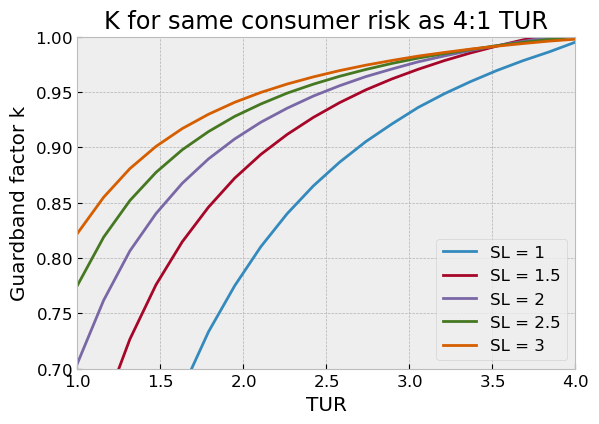

In [5]:
sameTUR = 4

SLlist = np.array([1, 1.5, 2, 2.5, 3])
TURlist = np.linspace(1, 4, 20)
k = np.zeros((len(SLlist), len(TURlist)))
dproc = stats.norm(loc=0, scale=1)
for j, SL in enumerate(SLlist):
    targetpfa = risk.PFA_deaver(SL, sameTUR)     # Calculate same risk percent as 4:1 TUR for this sigma with no GB
    for i, TUR in enumerate(TURlist):
        dtest = stats.norm(loc=0, scale=1/TUR)   # Define test distribution using TUR
        k[j,i] = risk.guardband(dproc, dtest, -SL, SL, targetpfa, approx=True)
        k[j,i] = (SL - k[j,i])/SL          # Convert relative guardband to ratio as defined in Deaver
    plt.plot(TURlist, k[j,:], label='SL = {:g}'.format(SL))
    
plt.legend(loc='best')
plt.xlabel('TUR')
plt.ylabel('Guardband factor k')
plt.ylim(.7, 1)
plt.xlim(1, 4)
plt.title('K for same consumer risk as {}:1 TUR'.format(sameTUR));